# Object Detection using YOLOv5 and OpenCV DNN

## Convert PyTorch Models to ONNX
### Clone Ultralytics/yolov5 Repository

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
!pip install onnx

### Download YOLOv5 PyTorch Models

In [ ]:
!wget https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5n.pt

### Export to ONNX

In [ ]:
!python export.py --weights models/yolov5n.pt --include onnx

## YOLOv5 OpenCV DNN
The following chart demonstrates the YOLOv5 with OpenCV DNN workflow.

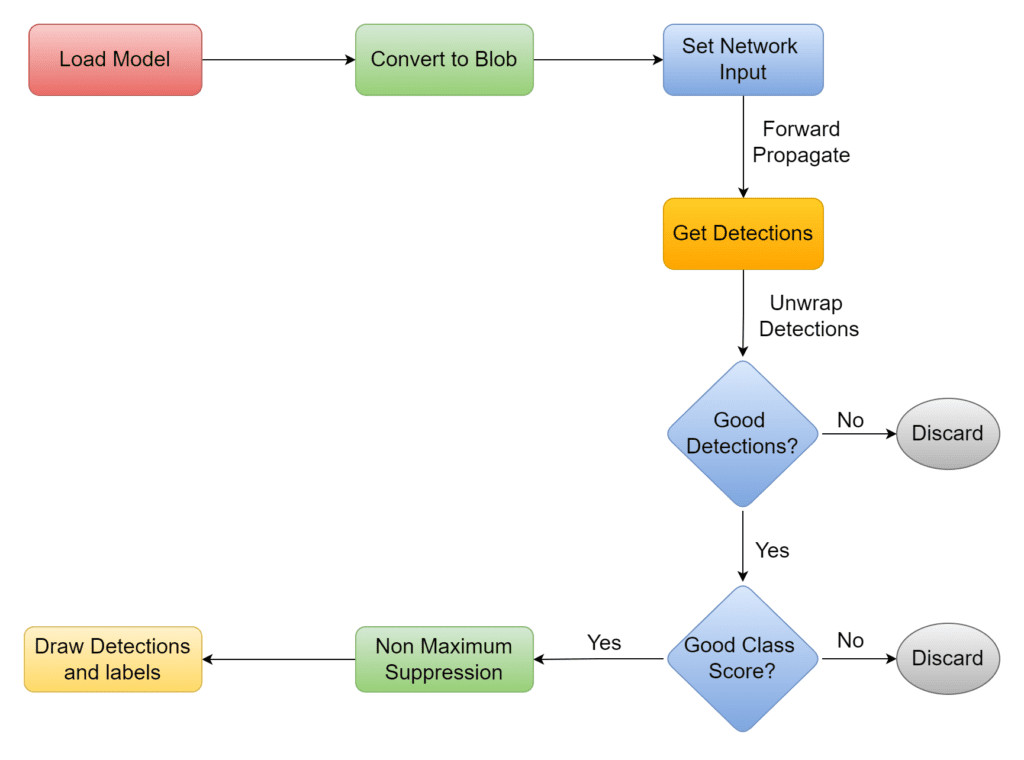

In [1]:
from IPython.display import Image
Image(filename='pic/yolov5-opencv-dnn-1024x760.jpg')

### Import Libraries

In [1]:
import cv2
import numpy as np

### Define Global Parameters

The constants __INPUT_WIDTH__ and __INPUT_HEIGHT__ are for the blob size. The BLOB stands for Binary Large Object. It contains the data in readable raw format. The image must be converted to a blob so the network can process it. In our case, it is a 4D array object with the shape (1, 3, 640, 640).

- __SCORE_THRESHOLD__: To filter low probability class scores.
- __NMS_THRESHOLD__: To remove overlapping bounding boxes.
- __CONFIDENCE_THRESHOLD__: Filters low probability detections.

We will discuss more of these parameters while going through the code.

In [2]:
# Constants.
INPUT_WIDTH = 640
INPUT_HEIGHT = 640
SCORE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.45
CONFIDENCE_THRESHOLD = 0.45

# Text parameters.
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

# Colors
BLACK  = (0,0,0)
BLUE   = (255,178,50)
YELLOW = (0,255,255)
RED = (0,0,255)

### Draw YOLOv5 Inference Label
The function `draw_label` annotates the class names anchored to the top left corner of the bounding box. The code is fairly simple. We pass the text string as a label in the argument, which is passed to the OpenCV function `getTextSize()`.

It returns the bounding box size that the text string would take up. These dimension values are used to draw a black background rectangle on which the label is rendered by `putText()` function.

In [3]:
def draw_label(input_image, label, left, top):
    """Draw text onto image at location."""
    
    # Get text size.
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]
    # Use text size to create a BLACK rectangle. 
    cv2.rectangle(input_image, (left, top), (left + dim[0], top + dim[1] + baseline), BLACK, cv2.FILLED)
    # Display text inside the rectangle.
    cv2.putText(input_image, label, (left, top + dim[1]), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv2.LINE_AA)

### PRE-PROCESSING YOLOv5 Model
The function `pre–process` takes the image and the network as arguments. At first, the image is converted to a blob. Then it is set as input to the network. The function `getUnconnectedOutLayerNames()` provides the names of the output layers. It has features of all the layers, through which the image is forward propagated to acquire the detections. After processing, it returns the detection results.

In [4]:
def pre_process(input_image, net):
	# Create a 4D blob from a frame.
	blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WIDTH, INPUT_HEIGHT), [0,0,0], 1, crop=False)

	# Sets the input to the network.
	net.setInput(blob)

	# Runs the forward pass to get output of the output layers.
	output_layers = net.getUnconnectedOutLayersNames()
	outputs = net.forward(output_layers)
	# print(outputs[0].shape)

	return outputs

### POST-PROCESSING YOLOv5 Prediction Output

In the previous function `pre_process`, we get the detection results as an object. It needs to be unwrapped for further processing. Before discussing the code any further, let us see the shape of this object and what it contains.

The returned object is a 2-D array. The output depends on the size of the input. For example, with the default input size of 640, we get a 2D array of size 25200×85 (rows and columns). The rows represent the number of detections. So each time the network runs, it predicts 25200 bounding boxes. Every bounding box has a 1-D array of 85 entries that tells the quality of the detection. This information is enough to filter out the desired detections.

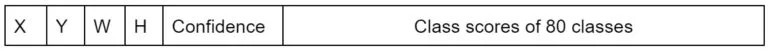

In [6]:
Image(filename='pic/detections-768x51.jpg')

The first two places are normalized center coordinates of the detected bounding box. Then comes the normalized width and height. Index 4 has the confidence score that tells the probability of the detection being an object. The following 80 entries tell the class scores of 80 objects of the COCO dataset 2017, on which the model has been trained.

#### Filter Good Detections given by YOLOv5 Models

While unwrapping, we need to be careful with the shape. With OpenCV-Python 4.5.5, the object is a tuple of a 3-D array of size 1x row x column. It should be row x column. Hence, the array is accessed from the zeroth index. 

The network generates output coordinates based on the input size of the blob,  i.e. 640. Therefore, the coordinates should be multiplied by the resizing factors to get the actual output. The following steps are involved in unwrapping the detections.

1. Loop through detections.
2. Filter out good detections.
3. Get the index of the best class score.
4. Discard detections with class scores lower than the threshold value.

#### Remove Overlapping Boxes Predicted by YOLOv5

After filtering good detections, we are left with the desired bounding boxes. However, there can be multiple overlapping bounding boxes, which may look like the following.

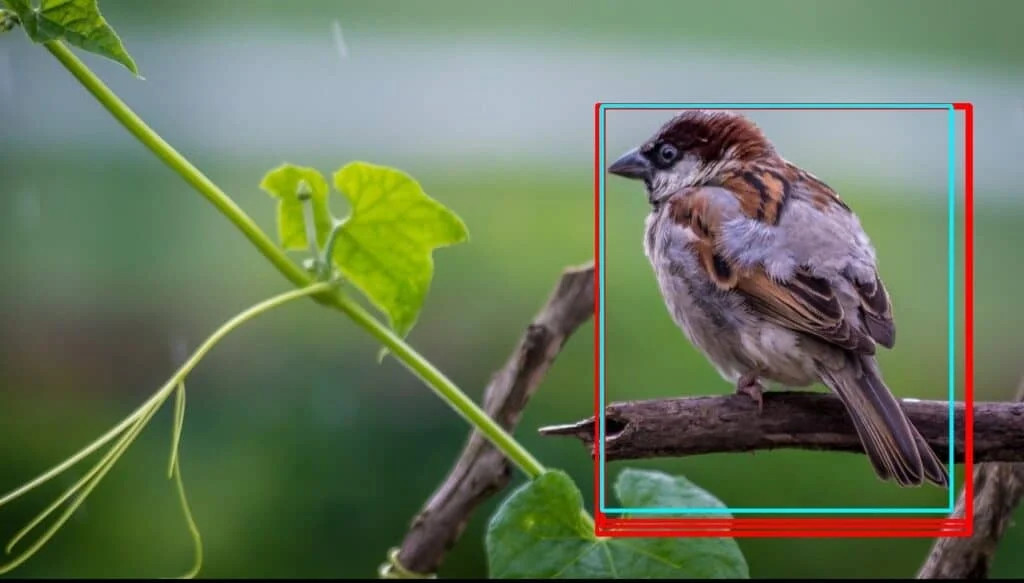

In [7]:
Image(filename='pic/without-non-maximum-suppression-1024x583.jpg')

This is solved by performing `Non-Maximum Suppression`. The function `NMSBoxes()` takes a list of boxes, calculates IOU (Intersection Over Union), and decides to keep the boxes depending on the NMS_THRESHOLD. 

In [5]:
def post_process(input_image, outputs):
	# Lists to hold respective values while unwrapping.
	class_ids = []
	confidences = []
	boxes = []

	# Rows.
	rows = outputs[0].shape[1]

	image_height, image_width = input_image.shape[:2]

	# Resizing factor.
	x_factor = image_width / INPUT_WIDTH
	y_factor =  image_height / INPUT_HEIGHT

	# Iterate through 25200 detections.
	for r in range(rows):
		row = outputs[0][0][r]
		confidence = row[4]

		# Discard bad detections and continue.
		if confidence >= CONFIDENCE_THRESHOLD:
			classes_scores = row[5:]

			# Get the index of max class score.
			class_id = np.argmax(classes_scores)

			#  Continue if the class score is above threshold.
			if (classes_scores[class_id] > SCORE_THRESHOLD):
				confidences.append(confidence)
				class_ids.append(class_id)

				cx, cy, w, h = row[0], row[1], row[2], row[3]

				left = int((cx - w/2) * x_factor)
				top = int((cy - h/2) * y_factor)
				width = int(w * x_factor)
				height = int(h * y_factor)
			  
				box = np.array([left, top, width, height])
				boxes.append(box)

	# Perform non maximum suppression to eliminate redundant overlapping boxes with
	# lower confidences.
	indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
	for i in indices:
		box = boxes[i]
		left = box[0]
		top = box[1]
		width = box[2]
		height = box[3]
		cv2.rectangle(input_image, (left, top), (left + width, top + height), BLUE, 3*THICKNESS)
		label = "{}:{:.2f}".format(classes[class_ids[i]], confidences[i])
		draw_label(input_image, label, left, top)

	return input_image


### Main Function
Finally, we load the model. Perform pre-processing and post-processing followed by displaying efficiency information.

In [8]:
# Load class names.
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Load image.
frame = cv2.imread('sample.jpg')

# Give the weight files to the model and load the network using them.
modelWeights = "yolov5n.onnx"
net = cv2.dnn.readNet(modelWeights)

# Process image.
detections = pre_process(frame, net)
img = post_process(frame.copy(), detections)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
print(label)
cv2.putText(img, label, (20, 40), FONT_FACE, FONT_SCALE, RED, THICKNESS, cv2.LINE_AA)

# cv2.imshow('Output', img)
# cv2.waitKey(0)

Inference time: 122.99 ms


array([[[ 91,  86,  55],
        [ 92,  86,  57],
        [ 95,  84,  57],
        ...,
        [ 27,  57, 228],
        [ 50,  85, 249],
        [ 67, 105, 255]],

       [[ 81,  73,  43],
        [ 81,  73,  44],
        [ 82,  71,  44],
        ...,
        [ 28,  58, 231],
        [ 42,  78, 246],
        [ 54,  92, 255]],

       [[ 78,  67,  37],
        [ 79,  67,  39],
        [ 79,  66,  40],
        ...,
        [ 23,  53, 231],
        [ 33,  68, 242],
        [ 41,  79, 251]],

       ...,

       [[ 51,  47,  22],
        [ 51,  47,  22],
        [ 52,  48,  23],
        ...,
        [ 49,  51,  32],
        [ 49,  51,  32],
        [ 49,  51,  32]],

       [[ 48,  46,  22],
        [ 48,  46,  22],
        [ 48,  46,  22],
        ...,
        [ 49,  51,  32],
        [ 49,  51,  32],
        [ 49,  51,  32]],

       [[ 47,  45,  21],
        [ 47,  45,  21],
        [ 47,  45,  21],
        ...,
        [ 49,  51,  32],
        [ 49,  51,  32],
        [ 49,  51,  32]]

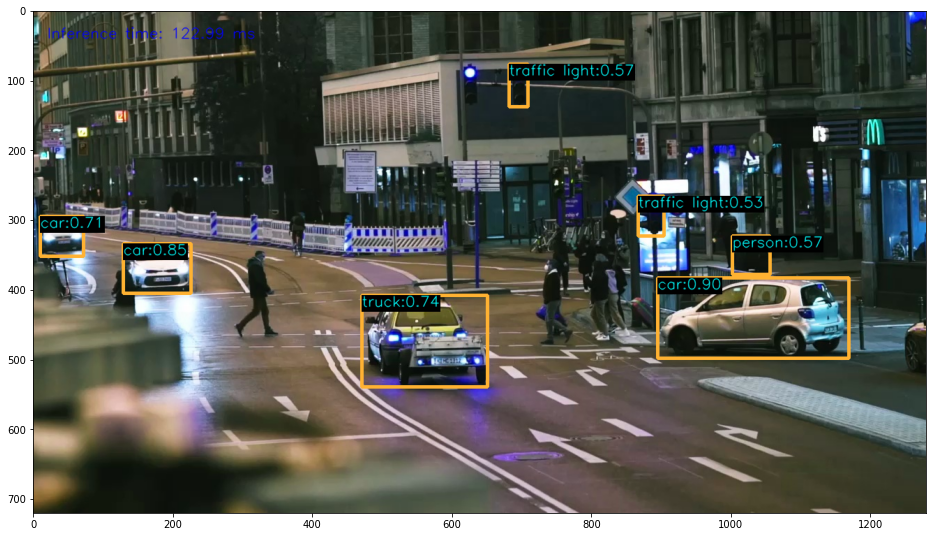

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
plt.imshow(img)